# Laboratorium 3

### Konfiguracja

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.added_points.append(PointsCollection())
         
    def add_line(self, event):
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.added_lines.append(LinesCollection())

    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [6]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points = [], **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines = [], **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(callback.add_line)
        return [b_prev, b_next, b_add_point, b_add_line]
    
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes
        
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(self.callback)
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        


### Przykłady użycia

##### Proste rysowanie

Należy utworzyć zmienną z obiuektem `Plot`, który przyjmuje jako parametr konstruktora listę scen lub string ze scenami w formacie json. Następnie po dodaniu wszystkich, na samym końcu programu, należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


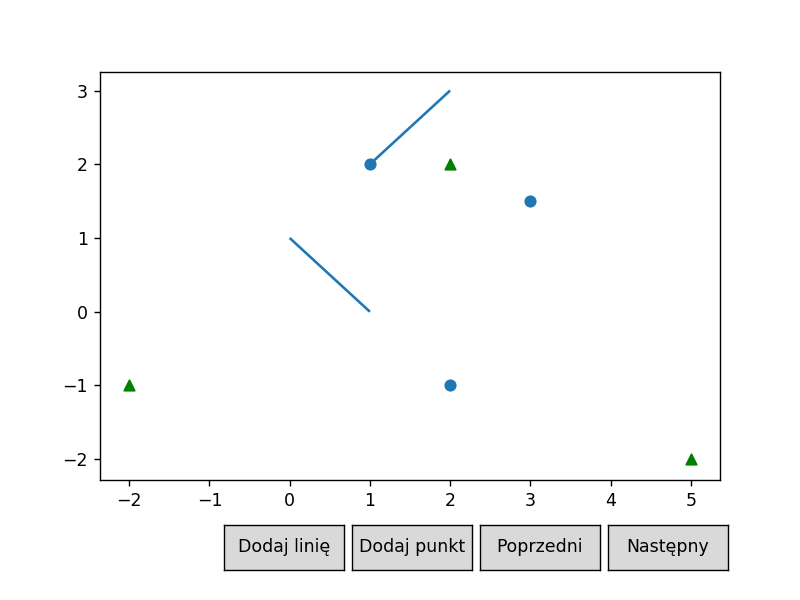

In [7]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red', s=1), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot = Plot(scenes)
plot.add_scene(Scene([PointsCollection([(2, 1)])], [LinesCollection([[(1,2),(2,3)]])]))

plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

<IPython.core.display.Javascript object>


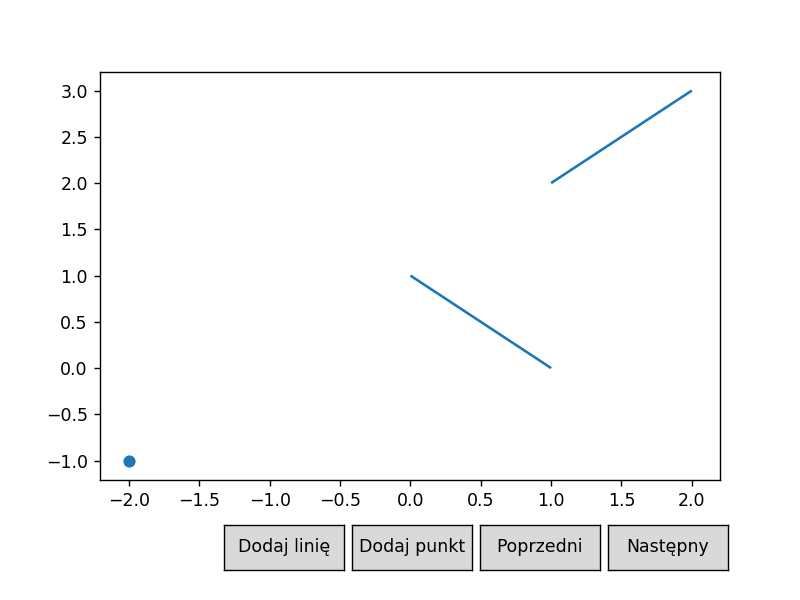

In [8]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.txt: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

<IPython.core.display.Javascript object>


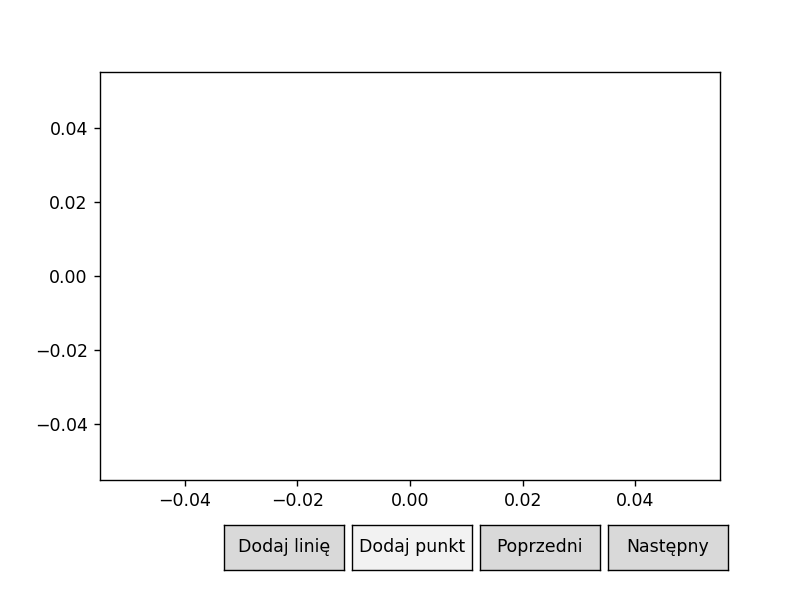

In [18]:
#Dodaj tu punkty i/lub odcinki!
plot1 = Plot()
plot1.draw()

<IPython.core.display.Javascript object>


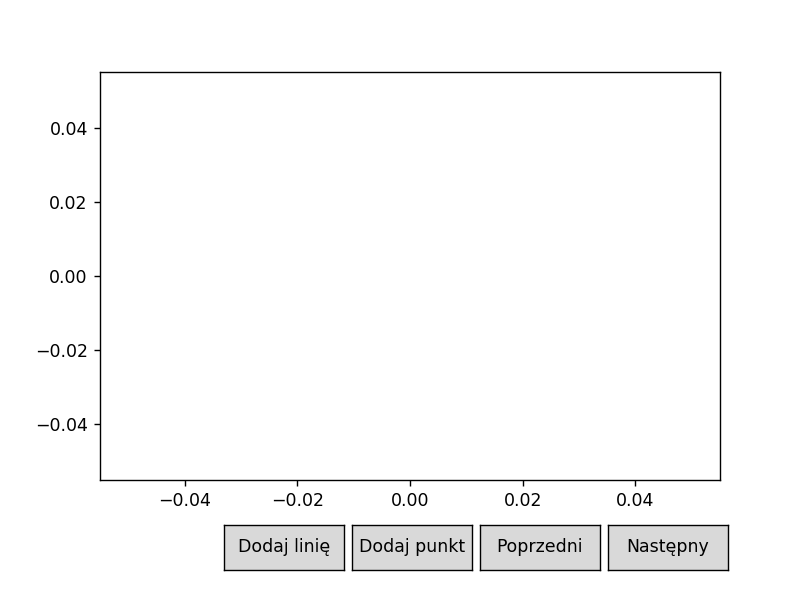

In [10]:
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()

### Rozwiązanie

In [19]:
def getPoint(minCoord, maxCoord, pointSet):
    point1 = (round(np.random.uniform(minCoord,maxCoord),5),round(np.random.uniform(minCoord,maxCoord),5))
    point2 = (round(np.random.uniform(minCoord,maxCoord),5),round(np.random.uniform(minCoord,maxCoord),5))
    while(point1 in pointSet or point2 in pointSet or point1[0]==point2[0]):
        point1 = (round(np.random.uniform(minCoord,maxCoord),5),round(np.random.uniform(minCoord,maxCoord),5))  
        point2 = (round(np.random.uniform(minCoord,maxCoord),5),round(np.random.uniform(minCoord,maxCoord),5))
    pointSet.append(point1)
    pointSet.append(point2)
    return [point1,point2]
  
    
def generateLines(linesCount, minCoord, maxCoord):
    pointSet  = []
    linesSet = []
    for i in range(linesCount):
        linesSet.append(getPoint(minCoord,maxCoord,pointSet))
    return linesSet

<IPython.core.display.Javascript object>


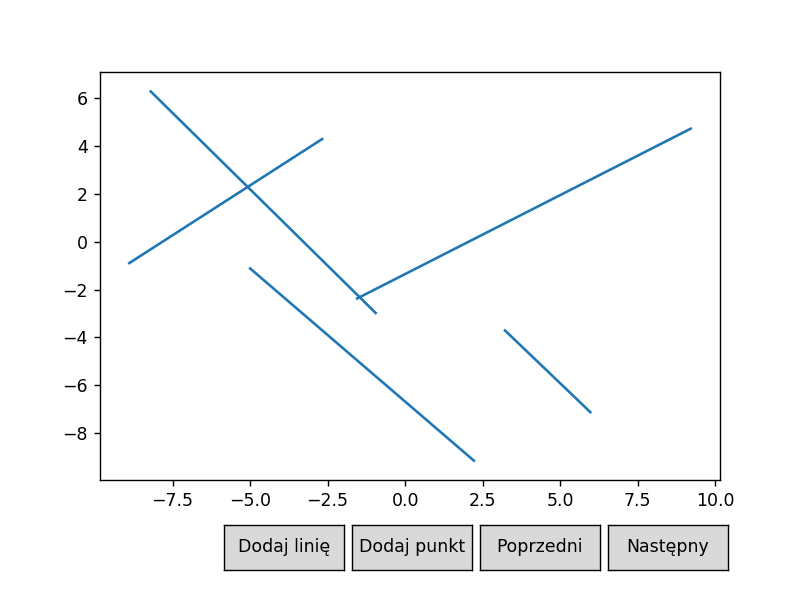

In [20]:
%matplotlib notebook
lines = generateLines(5,-10,10)
plot = Plot([Scene([PointsCollection([])],[LinesCollection(lines)])])
plot.draw()

##  Struktura stanu

In [14]:
#elementy struktury stanu

import math

ABOVE, BELOW, EQUAL = (1, -1, 0)
EPS = 1e-6


def get_point_orientation_relative_to_line(point, line):
    start = line.start
    end = line.end
    if point == start or point == end:
        return EQUAL

    result = start[0] * end[1] + end[0] * point[1] + point[0] * start[1] - end[0] * start[1] - start[0] * point[1] - point[0] * end[1]
    sign = -1 if result < 0 else 1
    result = math.fabs(result)

    if result > EPS:
        if sign == 1:
            return ABOVE

        else:
            return BELOW
    return EQUAL


class StateSegment:
    def __init__(self, segment):
        self.segment = segment
        self.start = segment.start
        self.end = segment.end
        self.orientation_point = segment.start


    #def to_tuple(self):
    #    return self.segment.to_tuple()


    def from_tuple(cls, raw_tuple):
        return cls(Segment.from_tuple(raw_tuple))

    def __lt__(self, other):
        if self.orientation_point[0] >= other.orientation_point[0]:
            orientation = get_point_orientation_relative_to_line(self.orientation_point, other.segment)
        else:
            orientation = -get_point_orientation_relative_to_line(other.orientation_point, self.segment)

        return True if orientation == ABOVE or \
                       (orientation == EQUAL and
                        get_point_orientation_relative_to_line(self.end, other.segment) == ABOVE) else False

    def __eq__(self, other):
        return True if get_point_orientation_relative_to_line(self.orientation_point, other.segment) == EQUAL else False


class Segment:
    def __init__(self, start, end):
        self.end = end
        self.start = start

    def to_tuple(self):
        return self.start.to_tuple() + self.end.to_tuple()

    '''
    @classmethod
    def from_tuple(cls, raw_tuple):
        start = raw_tuple[0]
        end = raw_tuple[1]
        if end[0] < start[0]:
            start, end = end, start
        return cls(Point(start[0], start[1]), Point(end[0], end[1]))
    '''

    def __eq__(self, other):
        return self.end == other.end and self.start == other.start

    def __repr__(self, *args, **kwargs):
        return "[" + str(self.start) + ", " + str(self.end) + "]"

## Algorithm implementation

Event types are as following:
1. start of a line segment
2. intersection
3. end of a line segment

In [21]:
def determiner1(a,b,c):
    return a[0]*b[1] + a[1]*c[0] + b[0]*c[1] - a[0]*c[1] - a[1]*b[0] - b[1]*c[0]


def lineCoefficients(p1, p2):
    A = (p1[1] - p2[1])
    B = (p2[0] - p1[0])
    C = (p1[0]*p2[1] - p2[0]*p1[1])
    return A, B, -C

def doIntersect(segment1, segment2):
    if determiner1(segment1[0],segment1[1],segment2[0]) * determiner1(segment1[0],segment1[1],segment2[1]) > 0: return False
    if determiner1(segment2[0],segment2[1],segment1[0]) * determiner1(segment2[0],segment2[1],segment1[1]) > 0: return False
    return True

def calculateIntersection(segment1, segment2):
    if not (doIntersect(segment1,segment2)): return False
    LineC1 = lineCoefficients(segment1[0],segment1[1])
    LineC2 = lineCoefficients(segment2[0],segment2[1])
    MainDet  = LineC1[0] * LineC2[1] - LineC1[1] * LineC2[0]
    if MainDet != 0:
        xDet = LineC1[2] * LineC2[1] - LineC1[1] * LineC2[2]
        yDet = LineC1[0] * LineC2[2] - LineC1[2] * LineC2[0]
        x = xDet / MainDet
        y = yDet / MainDet
        return x,y
    return False




In [22]:
def Bruteforce(lines):
    points = []
    for x in lines:
        for y in lines:
            z = calculateIntersection(x,y)
            if x != y and z:
                points.append(z)
    return points



In [23]:

def intersection(a, b, eps=1e-6):
    r = (a.end[0]-a.start[0], a.end[1]-a.start[1])
    s = (b.end[0]-b.start[0], b.end[1]-b.start[1])
    
    rxs = r[0]*s[1] - r[1]*s[0] #if rxs = 0 then lines colinear
    
    if(rxs > eps or rxs < -eps):
        q_p = (b.start[0] - a.start[0], b.start[1] - a.start[1])
        t = (q_p[0]*s[1] - q_p[1]*s[0]) / rxs
        u = (q_p[0]*r[1] - q_p[1]*r[0]) / rxs
        
        if((t >= 0. and t<=1.) and (u >= 0. and u <= 1.)):
            return (round(a.start[0] + t*r[0], 8), round(a.start[1] + t*r[1], 8))
        else:
            return None
    else:
        return None

def check_intersection(segment1, segment2, events, intersections):
    if (not segment1 is None) and (not segment2 is None):
        intersection_point = intersection(segment1,segment2)
        if intersection_point and intersection_point not in intersections:
            intersections.add(intersection_point)
            #event = (key = intersection_point, value = ([segment1,segment2], 0))
            events.insert(key = intersection_point, value = ([segment1,segment2], 1))

def process_segment(segment, state, events, intersections):
    state.insert(segment)
    
    neighbour1 = state.successor(segment)
    neighbour2 = state.predecessor(segment)
    
    check_intersection(segment,neighbour1, events, intersections)
    check_intersection(segment,neighbour2, events, intersections)
    
    




'''
def checkNeighboursInsert(eventStructure, stateStructure, event, lines,orientationPoints):
    
    events = []
    lineIndex = event.index
    key = StateSegment(Segment(lines[lineIndex][0],lines[lineIndex][1]),lineIndex)
    stateStructure.insert(key)
    
    neighbour1 = stateStructure.predecessor(key);
    neighbour2 = stateStructure.successor(key);
    
    if (neighbour1):
        if (stateStructure.successor(neighbour1) != key): print("coś popsute w insert w poprzedniku")
        intersection = calculateIntersection([neighbour1.start,neighbour1.end],[key.start,key.end])
        if intersection : events.append((intersection, [stateStructure.findNode(neighbour1).key.index,stateStructure.findNode(key).key.index], 1))
            
    neighbour2 = stateStructure.successor(key);
    
    if (neighbour2):
        if (stateStructure.predecessor(neighbour2) != key): print("coś popsute w insert w nastepniku")
        intersection = calculateIntersection([neighbour2.start,neighbour2.end],[key.start,key.end])
        if intersection : events.append((intersection, [stateStructure.findNode(key).key.index,stateStructure.findNode(neighbour2).key.index], 1))
            
    return events
  
def checkNeighboursDelete(eventStructure, stateStructure, event, lines,orientationPoints):
    
    events = []
    lineIndex = event.index
    node = StateSegment(Segment(lines[lineIndex][0],lines[lineIndex][1]),lineIndex)
    
    neighbour1 = stateStructure.predecessor(node);
    neighbour2 = stateStructure.successor(node);

    stateStructure.remove(node)
    
    if neighbour1 and neighbour2:
        
        if (stateStructure.successor(neighbour1) != neighbour2): print("coś popsute w delete w poprzedniku")
        if (stateStructure.predecessor(neighbour2) != neighbour1): 
            print(stateStructure.predecessor(neighbour2))
            print(neighbour1)
            print("coś popsute w delete w następniku")
            
        intersection = calculateIntersection([neighbour1.start,neighbour1.end],[neighbour2.start,neighbour2.end])
        if intersection : events.append((intersection, [stateStructure.findNode(neighbour1).key.index,stateStructure.findNode(neighbour2).key.index], 1))

    return events
    
def checkNeighboursIntersect(eventStructure, stateStructure, event, lines,orientationPoints):
    events = []
    lineIndex1 = event.index[0]
    lineIndex2 = event.index[1]
    
    above = StateSegment(Segment(lines[lineIndex1][0],lines[lineIndex1][1]),lineIndex1)
    below = StateSegment(Segment(lines[lineIndex2][0],lines[lineIndex2][1]),lineIndex2)
    
    
    #if(stateStructure.successor(below) != above): print("above nie jest poprzednikiem below")
    #if(stateStructure.predecessor(above) != below): print("below nie jest następnikiem above")
        
    stateStructure.remove(above)
    stateStructure.remove(below)
    
    above.orientationPoint = event.key
    below.orientationPoint = event.key
    
    newEvent1 = EventRedBlackTree.Node(key = event.key, index = lineIndex1)
    events = checkNeighboursInsert(eventStructure, stateStructure, newEvent1, lines,orientationPoints)
    newEvent2 = EventRedBlackTree.Node(key = event.key, index = lineIndex2)
    events += checkNeighboursInsert(eventStructure, stateStructure, newEvent2, lines,orientationPoints)

    
    return events
    #eventStructure.insert(event.key, lineIndex1, 0)
    #eventStructure.insert(event.key, lineIndex2, 0)
'''
x = 5
    

In [25]:
import copy
import tree

def sweep(lines):
    events = RBTree()
    state = RBTree()
    
    steps = []
    linesSegments = []
    for x in lines:
        linesSegments.append(Segment(x[0],x[1]))
    
    for segment in linesSegments:

        events.insert(key = segment.start, value = (segment, 0))
        events.insert(key = segment.end, value = (segment, 2))
        
    intersections = set()
    event = events.minimum()
    
    while(not event.value is None):
        
        if(event.value[1] == 0):
            segment = StateSegment(event.value[0])
            process_segment(segment, state, events, intersections)
            
        elif(event.value[1] == 2):
            segment = event.value[0]
            state_segment = StateSegment(segment)
            
            neighbour1 = state.successor(state_segment)
            neighbour2 = state.predecessor(state_segment)
            
            state.remove(state_segment)
            
            check_intersection(neighbour1, neighbour2, events, intersections)
        else:
            state_segment1 = StateSegment(event.value[0][0])
            state_segment2 = StateSegment(event.value[0][1])
            
            state.remove(state_segment1)
            state.remove(state_segment2)
            
            state_segment1.orientation_point = event.key
            state_segment2.orientation_point = event.key
            
            process_segment(state_segment1, state, events, intersections)
            process_segment(state_segment2, state, events, intersections)
        
        events.remove(event.key)
        event = events.minimum()
    return list(intersections)

'''
def sweepingLine(lines):
    intersectionPoints = []

    eventStructure = EventRedBlackTree()
    stateStructure = RBTree()

    
    linesSegmentList = []
    for x in lines:
        if(x[0] < x[1]):
            linesSegmentList.append(x)
        else:
            linesSegmentList.append([x[1],x[0]])
            
    orientationPoints = []
    
    for x in linesSegmentList:
        orientationPoints.append(x[0])

    for id,x in enumerate(linesSegmentList):
        eventStructure.insert(x[0],id,0)
        eventStructure.insert(x[1],id,2)
    

            if(event.type == EventType.start):
            segment = StateSegment(event.segments)
            process_segment(segment, state, events, intersections)
        elif(event.type == EventType.end):
            segment = event.segments
            state_segment = StateSegment(segment)
            
            neighbour1 = state.successor(state_segment)
            neighbour2 = state.predecessor(state_segment)
            
            state.remove(state_segment)
            
            check_intersection(neighbour1, neighbour2, events, intersections)
        else:
            state_segment1 = StateSegment(event.segment1)
            state_segment2 = StateSegment(event.segment2)
            
            state.remove(state_segment1)
            state.remove(state_segment2)
            
            state_segment1.orientation_point = event.point
            state_segment2.orientation_point = event.point
            
            process_segment(state_segment1, state, events, intersections)
            process_segment(state_segment2, state, events, intersections) 
    
    while eventStructure.size != 0 :
        
        event = eventStructure.minimum()
        eventStructure.remove(event.key)
        
        if event.eventType == 0:              
            events = checkNeighboursInsert(eventStructure, stateStructure, event, linesSegmentList,orientationPoints)
            for i in events:
                if i[0] > event.key and not eventStructure.key_search(i[0]): eventStructure.insert(i[0],i[1],i[2])
              
            
        elif event.eventType == 1:
            intersectionPoints.append(event.key)
            events = checkNeighboursIntersect(eventStructure, stateStructure, event, linesSegmentList,orientationPoints)
            for i in events:
                if i[0] > event.key and not eventStructure.key_search(i[0]): eventStructure.insert(i[0],i[1],i[2])
        
        
        
        else :
            events = checkNeighboursDelete(eventStructure, stateStructure, event, linesSegmentList,orientationPoints)
            for i in events:
                if i[0] > event.key and not eventStructure.key_search(i[0]): eventStructure.insert(i[0],i[1],i[2])
            print("usuwam linie")

    print (len(stateStructure))
            
    return intersectionPoints
'''
x = 5

<IPython.core.display.Javascript object>


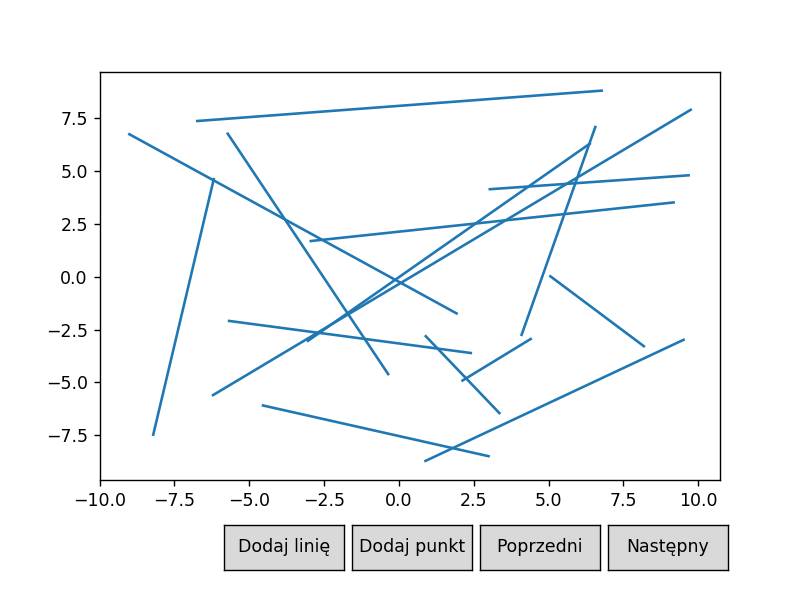

In [26]:
lines = generateLines(15,10,-10)
plot = Plot([Scene([PointsCollection([])],[LinesCollection(lines)])])
plot.draw()


<IPython.core.display.Javascript object>


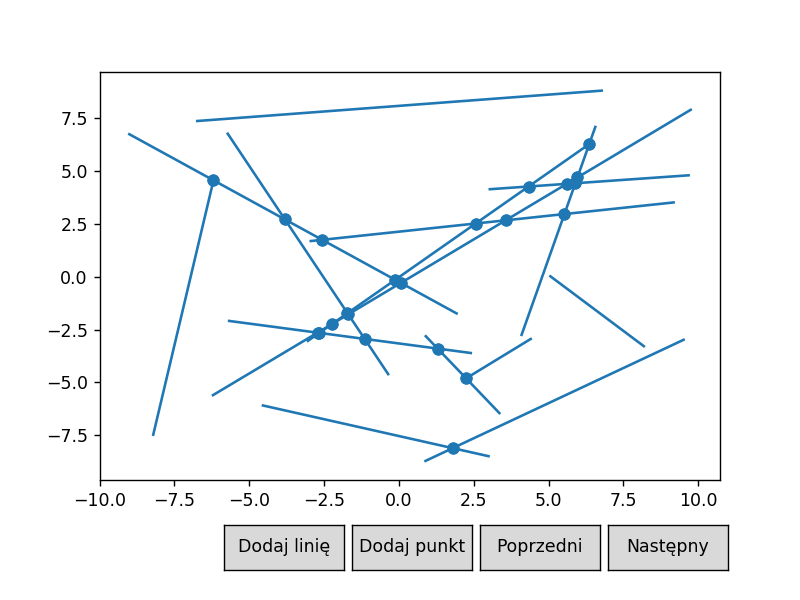

In [28]:
linesSegmentList = []
for x in lines:
    if(x[0] < x[1]):
        linesSegmentList.append(x)
    else:
        linesSegmentList.append([x[1],x[0]])

#for id,x in enumerate(linesSegmentList):
#print("%d   +   %f,%f  %f %f"%(id,x[0][0],x[0][1],x[1][0],x[1][1]))
points2 = sweep(lines)
points1 = Bruteforce(lines)

#print(len(points1))
#print(len(points2))

plot = Plot([Scene([PointsCollection(points1)],[LinesCollection(lines)]), Scene([PointsCollection(points2)],[LinesCollection(lines)])])
plot.draw()

(0, (1, 2))
(1, (4, 7))


<IPython.core.display.Javascript object>


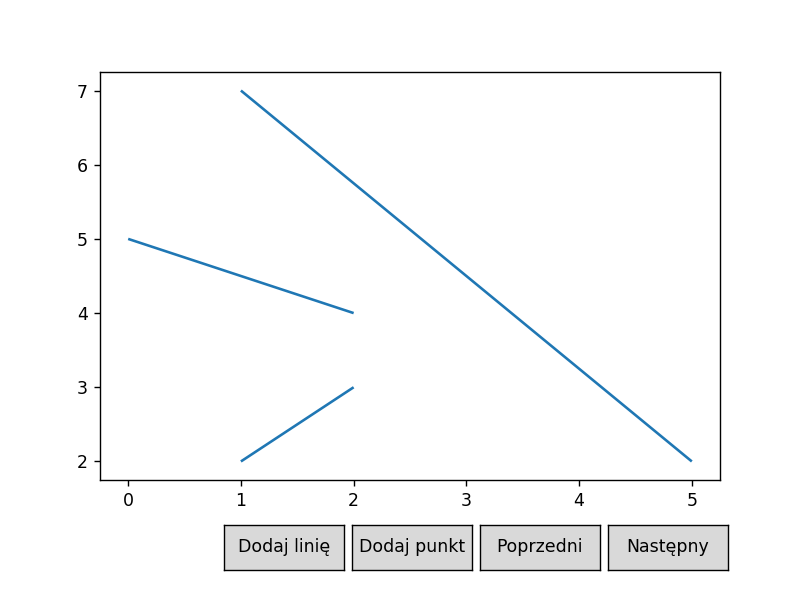

In [384]:

lines = [[(1,2),(2,3)],[(1,7),(5,2)],[(0,5),(2,4)]]

tree1 = RBTree()
tree1.insertNode(key =(0,(1,2)))
tree1.insertNode(key = (1,(4,7)))
tree1.insertNode(key = (2,(0,5)))

if (tree1.predecessor((2,(0,5))) != (1, (4, 7))): print(tree1.predecessor((2,(0,5)),"przodek srodka"))
    
if (tree1.successor((1,(4,7))) != (2, (0, 5))): print(tree1.predecessor((2,(0,5))), "nastepnik góry")
    
if (tree1.successor((2,(0,5))) != (0, (1, 2))): print(tree1.predecessor((2,(0,5))), "nastepnik środka")
    
if (tree1.predecessor((0,(1,2))) != (2, (0, 5))): print(tree1.predecessor((2,(0,5))), "przodek dołu")
    
tree1.remove((2,(0,5)))

print(tree1.successor((1,(4,7))))
print(tree1.predecessor((0,(1,2))))

#print(tree1.successor((0,(1,2))))
#print(tree1.successor((1,(4,7))))

#tree1.insertNode(key = (2,3),value=40)
#node = tree1.findNode((2,3))
#print(tree1.prevNode(tree1.findNode((2,3))).key)
#print(tree1.prevNode(tree1.findNode((1,3))).key)
#print(tree1.prevNode(tree1.findNode((1,2))))
#node = tree1.findNode((2,3))
#tree1.deleteNode(tree1.findNode((2,3)))
#tree1.deleteNode(tree1.findNode((1,3)))
#tree1.deleteNode(tree1.findNode((1,2)))


plot = Plot([Scene([],[LinesCollection(lines)])])
plot.draw()

NameError: name 'cmp' is not defined